In [27]:
import torch
import numpy as np
import time
import os

from typing import List, Dict, Optional
from collections import defaultdict

import matplotlib.pyplot as plt

import torchvision
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
from torchvision.ops import box_iou, box_convert
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pathlib import Path

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train, plot_losses, collate_detection, ConditionalIoUCrop, load_checkpoint, build_targets

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

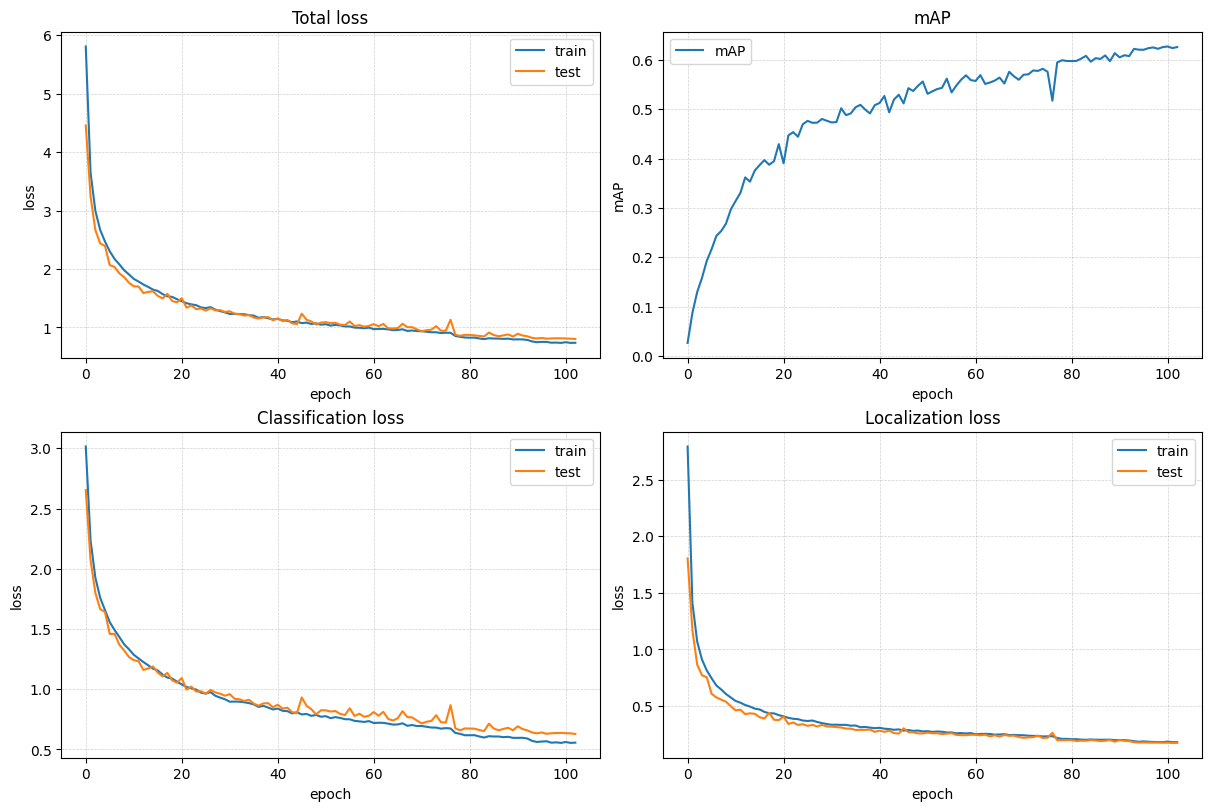

In [2]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "L1Loss_mAP_432_11_15_2025.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None

plot_losses(loss_dict)

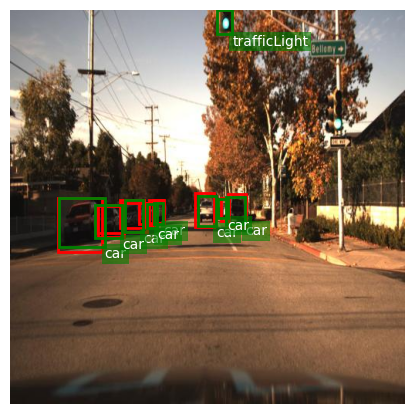

In [8]:
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((300, 300), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data_clean = CarImageClass.ImageClass(targ_dir=test_path, transform=min_tfms, file_pct=1, device=device)
test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device=device)

idx = np.random.randint(0, len(test_data))

testpred = ssdtestmodel.predict(test_data[idx][0].unsqueeze(dim=0).to(device), score_thresh=0.2, max_per_img=200)

# pred_boxs = testpred[0]['boxes'].to('cpu')
# pred_labels = ids_to_names(testpred[0]['labels'].tolist() if type(testpred[0]['labels']) != list else testpred[0]['labels'], mapping=id2name)

test_data_clean.show_with_box(index=idx, color='r', lw=2, label=False, pred_dict=testpred[0], pred_color='g', lw_pred=2, pred_label=True)

In [11]:
test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device=device)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssdtestmodel.predict(images.to(device), score_thresh=0.2, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

{'map': tensor(0.2130),
 'map_50': tensor(0.4319),
 'map_75': tensor(0.1819),
 'map_small': tensor(0.1500),
 'map_medium': tensor(0.3992),
 'map_large': tensor(0.6353),
 'mar_1': tensor(0.1456),
 'mar_10': tensor(0.2735),
 'mar_100': tensor(0.2740),
 'mar_small': tensor(0.2158),
 'mar_medium': tensor(0.4729),
 'mar_large': tensor(0.6857),
 'map_per_class': tensor([0.1089, 0.3457, 0.0685, 0.2036, 0.3380]),
 'mar_100_per_class': tensor([0.1633, 0.4069, 0.1157, 0.2927, 0.3912]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [3]:
test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device=device)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.5], class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssdtestmodel.predict(images.to(device), score_thresh=0.2, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

{'map': tensor(0.4319),
 'map_50': tensor(0.4319),
 'map_75': tensor(-1.),
 'map_small': tensor(0.3695),
 'map_medium': tensor(0.6647),
 'map_large': tensor(0.8681),
 'mar_1': tensor(0.2537),
 'mar_10': tensor(0.4953),
 'mar_100': tensor(0.4964),
 'mar_small': tensor(0.4412),
 'mar_medium': tensor(0.7101),
 'mar_large': tensor(0.8947),
 'map_per_class': tensor([0.2806, 0.6250, 0.1908, 0.5147, 0.5483]),
 'mar_100_per_class': tensor([0.3496, 0.6776, 0.2711, 0.5952, 0.5884]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [4]:
def to_tm_single(pred: Dict, tgt: Dict) -> tuple[Dict, Dict]:
    """
    pred: {"boxes": [K,4], "scores": [K], "labels": [K]}  # labels in 0..C-1, no background
    tgt:  {"boxes": [M,4], "labels": [M]}                 # assume same convention

    If your GT sometimes has background label, filter it here.
    """
    # predictions: already fine
    pred_tm = {
        "boxes":  pred["boxes"],
        "scores": pred["scores"],
        "labels": pred["labels"].long(),
    }

    # targets: if you *do* have a reserved background label, filter it here
    t_boxes  = tgt["boxes"]
    t_labels = tgt["labels"].long()

    # If you know GT never uses a background label, you can skip this mask.
    # Example if 0 were background:
    # keep = t_labels != 0
    # t_boxes, t_labels = t_boxes[keep], t_labels[keep]

    tgt_tm = {
        "boxes":  t_boxes,
        "labels": t_labels,
    }

    return pred_tm, tgt_tm


def batch_to_tm(preds_list: List[Dict], tgt_list: List[Dict]):
    preds_tm  = []
    targets_tm = []
    for pred, tgt in zip(preds_list, tgt_list):
        p_tm, t_tm = to_tm_single(pred, tgt)
        preds_tm.append(p_tm)
        targets_tm.append(t_tm)
    return preds_tm, targets_tm


In [5]:
@torch.no_grad()
def collect_and_eval(model, dataloader, device):
    model.eval()

    metric_coco = MeanAveragePrecision(
        box_format="xyxy",
        iou_type="bbox",
        class_metrics=True        # AP@[0.5:0.95] per class
        # default iou_thresholds is COCO: 0.5:0.05:0.95
    ).to(device)

    metric_05 = MeanAveragePrecision(
        box_format="xyxy",
        iou_type="bbox",
        class_metrics=True,
        iou_thresholds=[0.5],     # AP@0.5 only
    ).to(device)

    all_preds_tm:  List[Dict] = []
    all_targets_tm: List[Dict] = []

    for images, targets in dataloader:
        # images: adapt depending on your DataLoader
        if isinstance(images, list):
            imgs = torch.stack(images, dim=0).to(device)
        else:
            imgs = images.to(device)

        # send targets to device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        batch_preds = model.predict(imgs)  # list of dicts as you described

        preds_tm, targets_tm = batch_to_tm(batch_preds, targets)

        metric_coco.update(preds_tm, targets_tm)
        metric_05.update(preds_tm, targets_tm)

        all_preds_tm.extend(preds_tm)
        all_targets_tm.extend(targets_tm)

    res_coco = metric_coco.compute()
    res_05   = metric_05.compute()

    return res_coco, res_05, all_preds_tm, all_targets_tm


In [6]:
res_coco, res_05, all_preds_tm, all_targets_tm = collect_and_eval(ssdtestmodel, test_dataloader, device)

mAP_05_095 = res_coco["map"].item()     # mAP@[0.5:0.95]
mAP_05     = res_coco["map_50"].item()  # mAP@0.5

AP_05_095_per_class = res_coco["map_per_class"]   # AP@[0.5:0.95] per class
classes_coco        = res_coco["classes"]         # corresponding class indices

AP_05_per_class = res_05["map_per_class"]         # AP@0.5 per class
classes_05      = res_05["classes"]
AP_05_overall   = res_05["map"].item()            # overall AP@0.5


In [8]:
def gather_by_class(all_targets_tm, all_preds_tm, num_classes: int):
    """
    num_classes: detection classes, labels in 0..C-1 (no explicit background)
    Returns:
        gt_by_class[c][img_id] -> Tensor[M_i,4]
        pred_by_class[c]       -> list of (img_id, box_tensor, score_float)
    """
    gt_by_class = {c: defaultdict(list) for c in range(num_classes)}
    pred_by_class = {c: [] for c in range(num_classes)}

    for img_id, tgt in enumerate(all_targets_tm):
        boxes = tgt["boxes"]
        labels = tgt["labels"]
        for box, lab in zip(boxes, labels):
            c = int(lab.item())
            gt_by_class[c][img_id].append(box)

    for img_id, pred in enumerate(all_preds_tm):
        boxes  = pred["boxes"]
        scores = pred["scores"]
        labels = pred["labels"]
        for box, score, lab in zip(boxes, scores, labels):
            c = int(lab.item())
            pred_by_class[c].append((img_id, box, float(score)))

    # stack GT lists into tensors
    for c in range(num_classes):
        for img_id, box_list in gt_by_class[c].items():
            gt_by_class[c][img_id] = torch.stack(box_list, dim=0)

    return gt_by_class, pred_by_class


In [9]:
def match_class_at_iou(
    gt_boxes_by_img: dict,           # img_id -> Tensor[M_i,4]
    preds_for_class: list,           # list[(img_id, box_tensor, score_float)]
    iou_thr: float = 0.5,
):
    # sort by score desc
    preds_for_class = sorted(preds_for_class, key=lambda x: x[2], reverse=True)

    scores = []
    tp = []
    fp = []
    matched_ious = []

    gt_matched = {
        img_id: torch.zeros(boxes.size(0), dtype=torch.bool)
        for img_id, boxes in gt_boxes_by_img.items()
    }

    for img_id, box, score in preds_for_class:
        scores.append(score)

        if img_id not in gt_boxes_by_img or gt_boxes_by_img[img_id].numel() == 0:
            tp.append(0.0)
            fp.append(1.0)
            continue

        gt_boxes = gt_boxes_by_img[img_id]
        matched = gt_matched[img_id]

        ious = box_iou(box.unsqueeze(0), gt_boxes).squeeze(0)  # [M]
        best_iou, best_idx = ious.max(dim=0)

        if best_iou >= iou_thr and not matched[best_idx]:
            tp.append(1.0)
            fp.append(0.0)
            gt_matched[img_id][best_idx] = True
            matched_ious.append(float(best_iou))
        else:
            tp.append(0.0)
            fp.append(1.0)

    scores = torch.tensor(scores)
    tp     = torch.tensor(tp)
    fp     = torch.tensor(fp)
    matched_ious = torch.tensor(matched_ious) if matched_ious else torch.empty(0)
    num_gt = sum(b.size(0) for b in gt_boxes_by_img.values())
    return scores, tp, fp, matched_ious, num_gt


In [10]:
def precision_recall(scores, tp, fp, num_gt):
    if num_gt == 0 or scores.numel() == 0:
        return torch.empty(0), torch.empty(0)

    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)

    recall    = tp_cum / float(num_gt)
    precision = tp_cum / (tp_cum + fp_cum + 1e-6)
    return precision, recall


In [11]:
def f1_vs_threshold(scores, tp, fp, num_gt):
    if num_gt == 0 or scores.numel() == 0:
        return torch.empty(0), torch.empty(0)

    tp_cum = torch.cumsum(tp, dim=0)
    fp_cum = torch.cumsum(fp, dim=0)

    recall    = tp_cum / float(num_gt)
    precision = tp_cum / (tp_cum + fp_cum + 1e-6)

    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    thresholds = scores  # each element corresponds to “keep preds with score >= thresholds[i]”
    return thresholds, f1


In [12]:
def global_f1_curve(stats_per_class: dict[int, tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]]):
    """
    stats_per_class[c] = (scores_c, tp_c, fp_c, num_gt_c)
    """
    all_scores = []
    all_tp = []
    all_fp = []
    total_gt = 0

    for c, (scores, tp, fp, num_gt) in stats_per_class.items():
        if num_gt == 0 or scores.numel() == 0:
            continue
        all_scores.append(scores)
        all_tp.append(tp)
        all_fp.append(fp)
        total_gt += int(num_gt)

    if total_gt == 0 or not all_scores:
        return torch.empty(0), torch.empty(0)

    all_scores = torch.cat(all_scores)
    all_tp     = torch.cat(all_tp)
    all_fp     = torch.cat(all_fp)

    idx = torch.argsort(all_scores, descending=True)
    all_scores = all_scores[idx]
    all_tp     = all_tp[idx]
    all_fp     = all_fp[idx]

    return f1_vs_threshold(all_scores, all_tp, all_fp, total_gt)


In [31]:
def plot_iou_hist_global(iou_per_class: dict[int, torch.Tensor], iou_thr=0.5, bins=20):
    vals_list = [v for v in iou_per_class.values() if v.numel() > 0]
    if not vals_list:
        return

    vals = torch.cat(vals_list).cpu().numpy()
    plt.figure()
    plt.hist(vals, bins=bins, range=(iou_thr, 1.0))
    plt.xlabel(f"IoU for TP matches (≥ {iou_thr})")
    plt.ylabel("Count")
    plt.title("IoU histogram of matched predictions (all classes)")
    plt.grid(True)
    plt.show()


def plot_iou_hist_per_class(
    iou_per_class: Dict[int, torch.Tensor],
    class_names: Optional[List[str]] = None,
    iou_thr: float = 0.5,
    bins: int = 20,
):
    """
    Plot a IoU histogram for each class.

    Args:
        iou_per_class: dict[c] -> Tensor[n_tp_c] of IoU values in [iou_thr, 1]
        class_names:   optional list of names, class_names[c] is name for label c
        iou_thr:       minimum IoU used for matching (e.g. 0.5)
        bins:          number of histogram bins
    """
    classes = sorted(iou_per_class.keys())
    if not classes:
        return

    n_classes = len(classes)

    # decide grid layout: up to 3 columns
    n_cols = min(3, n_classes)
    n_rows = np.ceil(n_classes / n_cols).astype(int)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [[axes]]
    elif n_rows == 1:
        axes = [axes]
    elif n_cols == 1:
        axes = [[ax] for ax in axes]

    for idx, c in enumerate(classes):
        r = idx // n_cols
        col = idx % n_cols
        ax = axes[r][col]

        vals = iou_per_class[c]
        if vals.numel() == 0:
            # no TPs for this class: show empty axis with a note
            ax.text(
                0.5, 0.5,
                "no TP matches",
                ha="center", va="center", fontsize=9,
                transform=ax.transAxes,
            )
            ax.set_xlim(iou_thr, 1.0)
            ax.set_ylim(0, 1)
        else:
            arr = vals.cpu().numpy()
            ax.hist(arr, bins=bins, range=(iou_thr, 1.0))
            ax.set_xlim(iou_thr, 1.0)

        if class_names is not None and 0 <= c < len(class_names):
            title = f"class {c}: {class_names[c]}"
        else:
            title = f"class {c}"
        ax.set_title(title)

        ax.set_xlabel("IoU (TP matches)")
        ax.set_ylabel("Count")
        ax.grid(True, linestyle="--", alpha=0.5)

    # hide any unused subplots (if grid larger than number of classes)
    for idx in range(len(classes), n_rows * n_cols):
        r = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[r][col])

    fig.suptitle(f"IoU histograms per class (matched at IoU ≥ {iou_thr})", y=0.99)
    fig.tight_layout()
    plt.show()

In [14]:
def full_eval_with_curves(model, dataloader, device, num_classes: int):
    # 1. TorchMetrics + collect predictions
    res_coco, res_05, all_preds_tm, all_targets_tm = collect_and_eval(model, dataloader, device)

    # 2. Per-class GT / preds
    gt_by_class, pred_by_class = gather_by_class(all_targets_tm, all_preds_tm, num_classes)

    stats_per_class = {}  # c -> (scores, tp, fp, num_gt)
    iou_per_class   = {}  # c -> matched_ious

    for c in range(num_classes):
        scores, tp, fp, matched_ious, num_gt = match_class_at_iou(
            gt_by_class[c], pred_by_class[c], iou_thr=0.5
        )
        stats_per_class[c] = (scores, tp, fp, num_gt)
        iou_per_class[c]   = matched_ious

    # 3. Global F1 curve
    global_thr, global_f1 = global_f1_curve(stats_per_class)

    return {
        "res_coco": res_coco,
        "res_05": res_05,
        "stats_per_class": stats_per_class,
        "iou_per_class": iou_per_class,
        "global_f1_thresholds": global_thr,
        "global_f1": global_f1,
    }


In [17]:
results = full_eval_with_curves(ssdtestmodel, test_dataloader, device, 5)

In [29]:
test_data.classes

['biker', 'car', 'pedestrian', 'trafficLight', 'truck']

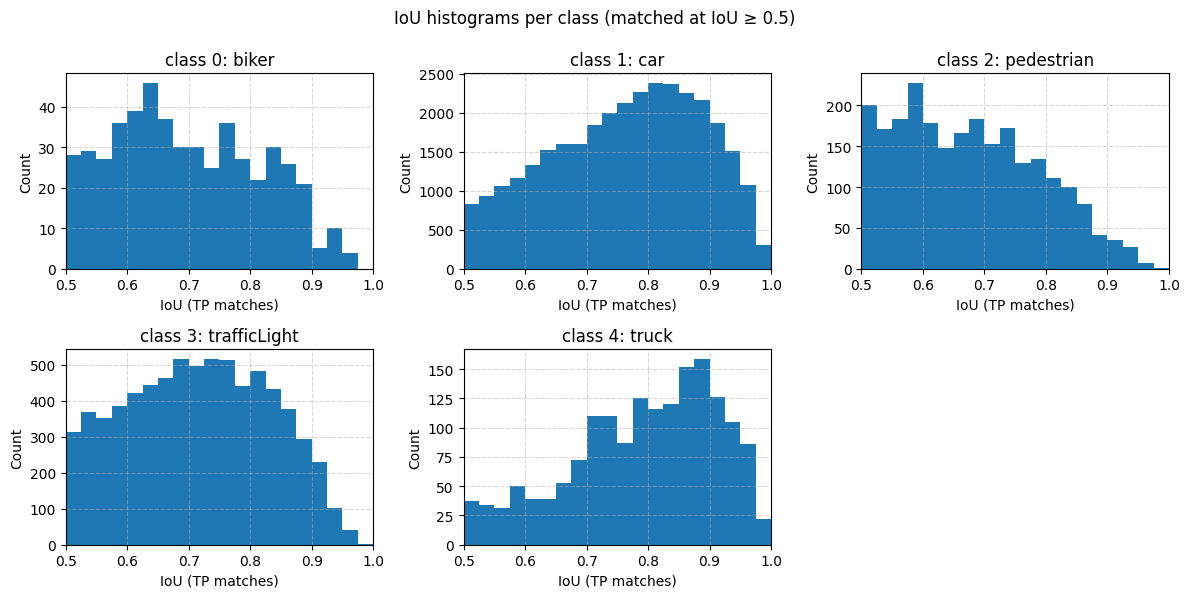

In [34]:
plot_iou_hist_per_class(iou_per_class=results['iou_per_class'], class_names=test_data.classes, iou_thr=0.5)

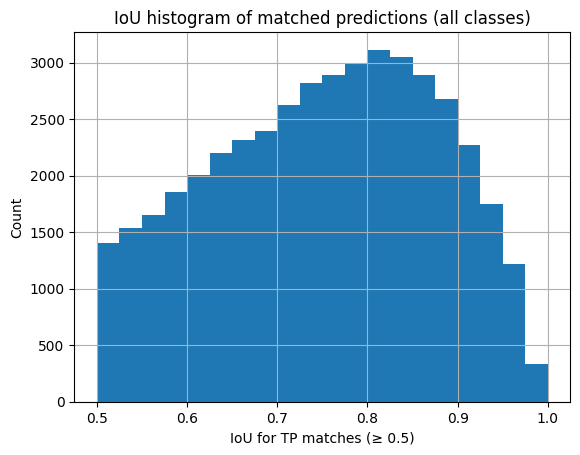

In [26]:
plot_iou_hist_global(iou_per_class=results['iou_per_class'])